# APRENDIZAJE DE CONJUNTOS Y BOSQUES ALEATORIOS

Supongamos que hacemos una pregunta compleja a miles de personas al azar y después agregamos sus respuestas. En la mayoría de los casos encontraremos que estas respuestas agregadas son mejores que la respuesta de un experto. Esto se denomina la *sabiduría de las masas*. De forma similar, si agregamos las predicciones de un grupo de predictores (tales como clasificadores o regresores), a menudo obtendremos mejores predicciones que con el mejor predictor individual. Un grupo de predictores se denomina *conjunto* (ensemble); por tanto, esta técnica es llamada *Aprendizaje de conjuntos* (ensemble learning) y un algoritmo de aprendizaje de conjunto se denomina *método de conjunto* (ensemble method).

Por ejemplo, podemos entrenar un grupo de clasificadores de árboles de decisión, cada uno en un subconjunto aleatorio diferente del conjunto de entrenamiento. Para hacer predicciones, basta con obtener las predicciones de todos los árboles individuales y luego predecir la clase que obtiene la mayoría de los votos. Tal conjunto de árboles de decisión se denomina *Bosque Aleatorio* (Random Forest) y, a pesar de su simplicidad, es uno de los algoritmos de Machine Learning más poderosos disponibles actualmente.

Además, como vimos en el capítulo 2, a menudo usaremos métodos de conjunto cerca del final del proyecto, una vez hayamos construido unos cuantos buenos predictores, para combinarlos en un predictor incluso mejor. De hecho, las soluciones ganadoras en las competiciones de Machine Learning a menudo involucran varios métodos de conjunto (el más famoso en la [competición del Premio de Netflix](http://netflixprize.com/)).

En este capítulo discutiremos los métodos de conjunto más populares, incluyendo *bagging*, *boosting*, *stacking* y algunos otros. También exploraremos los bosques aleatorios.

# Clasificadores de votación

Supongamos que hemos entrenado unos clasificadores, cada uno de ellos alcanzando una precisión del 80% aproximadamente. Podemos tener un clasificadores de Regresión Logística, un clasificador SVM, un clasificador Random Forest, un clasificador K-nearest neighbors y quizás algunos más.

![training_diverse_classifiers](images/ch07/training_diverse_classifiers.png)

Una forma muy sencilla de crear un clasificador aún mejor es agregar las predicciones de cada clasificador y predecir la clase que obtiene más votos. Este clasificador de votación-mayoritaria se denomina clasificador de *votación duro* (*hard voting*):

![hard_voting](images/ch07/hard_voting.png)

Sorprendentemente, este clasificador de votación a menudo alcanza una precisión más alta que el mejor clasificador del conjunto. De hecho, incluso si cada clasificador es un *aprendiz débil* (lo que significa que solo es un poco mejor que adivinar al azar), el conjunto aún puede ser un *aprendiz fuerte* (alcanzando alta precisión), siempre que haya un número suficiente de aprendices débiles y que sean lo suficientemente diversos.

¿Cómo es posible esto? La siguiente analogía puede ayudar a arrojar algo de luz sobre este misterio. Supongamos que tenemos una moneda ligeramente sesgada que tiene un 51% de probabilidad de caras y un 49% de probabilidad de salir cruz. Si la lanzamos 1.000 veces, generalmente obtendremos más o menos 510 cara y 490 cruz, por tanto mayoría de caras. Si hacemos los cálculos, encontraremos que la probabilidad de obtener una mayoría de caras despúes de 1.000 lanzamientos es cercana al 75%. Cuando más lancemos la moneda, mayor será la probabilidad (por ejemplo, con 10.000 lanzamientos, la probabilidad sube al 97%). Esto se debe a la *ley de los grandes números*: a medida que lanzamos la moneda, el ratio de caras se acercará cada vez más a la probabilidad de caras (51%). La siguiente figura muestra 10 series de lanzamientos de monedas sesgadas. Podemos ver que según aumenta el número de lanzamientos, el ratio de caras se acerca al 51%. Finalmente, las 10 series terminan tan cerca del 51% que están constantemente por encima del 50%.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

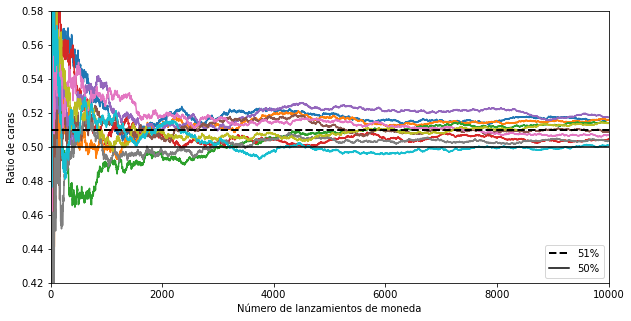

In [3]:
plt.figure(figsize=(10,5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Número de lanzamientos de moneda")
plt.ylabel("Ratio de caras")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58]);

Del mismo modo, supongamos que contruímos un conjunto conteniendo 1.000 clasificadores que son correctos individualmente solo el 51% de las veces (apenas mejor que adivinar aleatoriamente). Si predecimos la clase votada mayoritariamente ¡podemos esperar hasta un 75% de precisión! Sin embargo, esto es cierto solo si todos los clasificadores son perfectamente independientes, haciendo errores no correlacionados, lo que claramente no es el caso, dado que están entrenados en los mismos datos. Probablemente cometerán los mismos tipos de errores, por lo que habrá mucho votos mayoritarios para la clase equivocada, reduciendo la precisión del conjunto.

---

Los métodos de conjunto trabajan mejor cuando los predictores son tan independientes entre sí como sea posible. Una forma de obtener clasificadores diversos es entrenarlos usando algoritmos muy diferentes. Esto aumenta la probabilidad de que cometan tipos de errores muy diferentes, mejorando la precisión del conjunto.

---

El siguiente código crea y entrena un clasificador de votación en Scikit-Learn, compuesto por tres clasificadores diversos (el conjunto de entrenamiento es el dataset de lunas, que vimos en el capítulo 5).

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [6]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

Veamos cuál es la precisión de cada clasificador en el conjunto de prueba:

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Aquí lo tenemos. El clasificador de votación supera ligeramente a todos los clasificadores individuales.

Si todos los clasificadores son capaces de estimar las probabilidades de clase (es decir, tienen un método `predic_proba()`), entonces podemos decirle a Scikit-Learn que prediga la clase con la probabilidad más alta, promediada sobre todos los clasificadores individuales. Esto se denomina *voto suave* (*soft voting*). A menudo logra un mayor rendimiento que el voto duro porque da más peso a los votos con confianza más alta. Todo lo que necesitamos es reemplazar `voting="hard"` por `voting="soft"` y asegurar que todos los clasificadores pueden estimar las probabilidades de clase. Este no es el caso por defecto de la clase `SVC`, así que necesitamos establecer su hiperparámetro `probability` a `True` (esto hará que la clase `SVC` use validación cruzada para estimar las probabilidades de clase, ralentizando el entrenamiento, y añadirá un método `predic_proba()`). Si modificamos el código precedente para usar voto suave encontraremos que el clasificador de votación alcanza una precisión del 91,2%.

In [8]:
# Soft Voting

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging y Pasting

Una forma de obtener un conjunto diverso de clasificadores es usar algoritmos de entrenamiento muy diferentes, como acabamos de ver. Otro enfoque es usar el mismo algoritmo de entrenamiento por cada predictor, pero entrenándolo en diferentes subconjuntos aleatorios del conjunto de entrenamiento. Cuando el muestreo se ejecuta *con* reemplazo, este método se denomina *bagging* (abreviatura de *bootstrap aggregating*. En estadística, el remuestreo con reemplazo se denomina *bootstrapping*). Cuando el muestreo se ejecuta *sin* reemplazo se denomina *pasting*.

En otras palabras, tanto el bagging como el pasting permiten que las instancias de entrenamiento se muestreen varias veces en múltiples predictores, pero solo el bagging permite que las instancias de entrenamiento se muestreen varias veces para el mismo predictor. Este proceso de muestreo y entrenamiento está representado en la siguiente figura:

![pasting_bagging](images/ch07/pasting_bagging.png)

Una vez que todos los predictores son entrenados, el conjunto hace una predicción para una nueva instancia agregando simplemente las predicciones de todos los predictores. Típicamente, para la clasificación la función de agregación es la *moda estadística* (es decir, la predicción más frecuente, como un clasificador de voto duro) y la *media* para la regresión. Cada predictor individual tiene un sesgo mayor que si lo entrenáramos en el conjunto de entrenamiento original, pero la agregación reduce tanto el sesgo como la varianza. Generalmente, el resultado neto es que el conjunto tiene un sesgo similar pero una menor varianza que un único predictor entrenado en el conjunto de entrenamiento original.

Como podemos ver en la figura anterior, todos los predictores se pueden entrenar en paralelo, a través de diferentes cores de CPU o incluso diferentes servidores. De forma similar, las predicciones se pueden hacer en paralelo. Esta es una de las razones de por qué el bagging y el pasting son métodos tan populares: escalan muy bien.

## Bagging y Pasting en Scikit-Learn

Scikit-Learn ofrece una API sencilla tanto para bagging como para pasting con la clase `BaggingClassifier` (o `BaggingRegressor` para la regresión). El siguiente código entrena un conjunto de 500 clasificadores de árboles de decisión (alternativamente, `max_samples` puede establecerse a un float entre 0.0 y 1.0, en cuyo caso el número máximo de instancias a muestrear es igual al tamaño del conjunto de entrenamiento por `max_samples`), cada uno entrenado en 100 instancias de entrenamiento muestreadas aleatoriamente del conjunto de entrenamiento con reemplazo (este es un ejemplo  de bagging, pero si queremos usar pasting, solo hay que establecer `bootstrap=False`). El parámetro `n_jobs` le dice a Scikit-Learn el número de cores de CPU a usar para el entrenamiento y las predicciones (`-1` le dice a Scikit-Learn que use todos los cores disponibles):

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

---

`BaggingClassifier` ejecuta automáticamente voto suave en lugar de voto duro si el clasificador base puede estimar probabilidades de clase (es decir, si tiene un método `predict_proba()`), que es el caso de los clasificadores de árboles de decisión.

---

La siguiente figura compara los límites de decisión de un único árbol de decisión con los límites de decisión de un conjunto de bagging de 500 árboles (a partir del código precedente), ambos entrenados en el dataset de lunas. Como podemos ver, las predicciones del conjunto probablemente generalizarán mejor que las predicciones del árbol de decisión en solitario: el conjunto tiene un sesgo comparable pero una menor varianza (comete aproximadamente el mismo número de errores en el conjunto de prueba, pero el límite de decisión es menos irregular).

In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

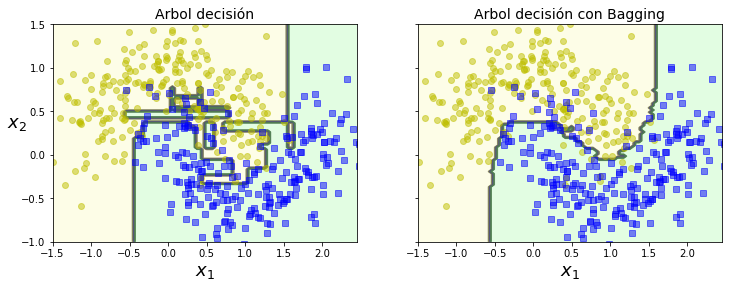

In [14]:
fix, axes = plt.subplots(ncols=2, figsize=(12,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Arbol decisión", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Arbol decisión con Bagging", fontsize=14)
plt.ylabel("");

Bootstrapping introduce un poco más de diversidad en los subconjuntos en los que se entrena cada predictor, por tanto, bagging termina con un sesgo ligeramente más alto que pasting, pero esto también significa que los predictores terminan estando menos correlacionados, por lo que se reduce la varianza del conjunto. En general, el bagging a menudo da como resultado mejores modelos, lo que explica por qué generalmente se prefiere. Sin embargo, si tenemos tiempo libre y potencia de CPU podemos usar validación cruzada para evaluar tanto bagging como pasting y seleccionar el que funcione mejor.

## Evaluación out-of-bag

Con bagging algunas instancias pueden ser muestreadas varias veces para cualquier predictor dado, mientras que otras puede que no sean muestreadas en absoluto. Por defecto, `BaggingClassifier` muestrea *m* instancias de entrenamiento con reemplazo (`bootstrat=True`), donde *m* es el tamaño del conjunto de entrenamiento. Esto significa que solo son muestreadas alrededor del 63% de las instancias de entrenamiento por cada predictor (si *m* crece, este ratio se aproxima a 1 - exp(-1) ≈ 63,212%). El 37% restante de las instancias de entrenamiento que no son muestreadas se denominan instancias *out-of-bag* (oob). Tengamos en cuenta que no es el mismo 37% para todos los predictores.

Dado que un predictor nunca ve las instancias oob durante el entrenamiento, puede evaluarse en esas instancias, sin necesidad de un conjunto de validación por separado. Podemos evaluar el conjunto mismo promediando las evaluaciones oob de cada predictor.

En Scikit-Learn para solicitar una evaluación oob automática después del entrenamiento podemos establecer `oob_score=True` cuando creamos un `BaggingClassifier`. El siguiente código demuestra esto. La puntuación resultante de la evaluación está disponible a través de la variable `oob_score`:

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

De acuerdo a esta evaluación oob, este `BaggingClassifier` es probable que alcance alrededor del 90,1% de precisión en el conjunto de prueba. Vamos a comprobarlo:

In [16]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

Obtenemos una precisión del 91,2% en el conjunto de prueba -suficientemente cerca.

# Random Patches y Random Subspaces

La clase `BaggingClassifier` también admite el muestreo de características. Esto se controla con dos hiperparámetros: `max_feautures` y `bootstrap_features`. Funcionan de la misma forma que `max_samples` y `bootstrap`, pero para muestrear características en lugar de instancias. Por lo tanto, cada predictor será entrenado en un subconjunto aleatorio de las características de entrada.

Esto es particularmente útil cuando se trata de entradas de alta dimensión (tales como imágenes). El muestreo tanto de instancias de entrenamiento como de características se denomina [método de *Random Patches*](https://homl.info/22). Mantener todas las instancias de entrenamiento (es decir, `bootstrap=False`y `max_samples=1.0`) pero muestreando las características (es decir, `bootstrap_features=True` y/o `max_features` menor que 1.0) se denomina [método de *Random Subspaces*](https://homl.info/23).

El muestreo de características da como resultado una mayor diversidad de predictores, intercambiando un poco más de sesgo por un poco menos de varianza.

# Bosques aleatorios

Como hemos discutido, un [Random Forest](https://homl.info/24) es un conjunto de árboles de decisión, generalmente entrenados a través del metodo bagging (o algunas veces pasting), típicamente con `max_samples` establecido al tamaño del conjunto de entrenamiento. En lugar de construir un `BaggingClassifier` y pasarle un `DecisionTreeClassifier`, podemos usar en su lugar la clase `RandomForestClassifier`, que es muchos más conveniente y optimizada para árboles de decisión (la clase `BaggingClassifier` será útil si queremos una "bolsa" de otras cosas que no sean árboles de decisión). De forma similar, existe una clase  `RandomForestRegressor` para tareas de regresión. El código siguiente entrena un clasificador Random Forest con 500 árboles (cada uno limitado a un máximo de 16 nodos), usando todos los cores de CPU disponibles:

In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

Con algunas excepciones, un `RandomForestClassifier` tiene todos los hiperparámetros de un `DecisionTreeClassifier` (para controlar cómo crecen los árboles), más todos los hiperparámetros de un `BagginClassifier` para controlar el conjunto en sí. Existen algunas notables excepciones: `splitter` está ausente (forzado a "`random`"), `presort` está ausente (forzado a `False`), `max_samples` está ausente (forzado a `1.0`) y `base_estimator` está ausente (forzado a `DecisionTreeClassifier` con los hiperparámetros proporcionados).

El algoritmo Random Forest introduce aleatoriedad extra cuando crecen los árboles; en lugar de buscar la mejor característica cuando divide un nodo (ver capítulo 6), busca la mejor característica entre un subconjunto aleatorio de características. Esto resulta en una mayor diversidad de árboles, con (una vez más) un intercambio de mayor sesgo por menor varianza, obteniendo generalmente un mejor modelo global. El siguiente `BaggingClassifier` es equivalente aproximadamente al anterior `RandomForestClassifier`:

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [19]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.984

## Arboles-Extra

Cuando cultivas un árbol en un Random Forest, en cada nodo solo se considera un subconjunto aleatorio de las características para la división (como se discutió anteriormente). Es posible hacer que los árboles sean incluso más aleatorios usando umbrales aleatorios para cada característica en lugar de buscar los mejores umbrales posibles (como hacen los árboles de decisión normales).

Un bosque de tales árboles extremadamente aleatorios se denomina simplemente un conjunto de *[árboles extremadamente aleatorios](https://homl.info/25)* (o *Arboles-Extra*, para abreviar). Una vez más, esto intercambia mayor sesgo por una menor varianza. También hace que los Arboles-Extra sean mucho más rápidos de entrenar que los Random Forest normales ya que encontrar el mejor umbral posible para cada característica en cada nodo es una de las tareas que más tiempo requiere para cultivar un árbol.

Podemos crear un clasificador de Arbol-Extra usando la clase de Scikit-Learn `ExtraTreesClassifier`. Su API es idéntica a la clase `RandomForestClassifier`. De forma similar, la clase `ExtraTreesRegresor` tiene la misma API que la clase `RandomForestRegressor`.

---

Es difícil saber de antemano si un `RandomForestClassifier` se ejecutará mejor o peor que un `ExtraTreesClassifier`. Generalmente, la única forma de averiguarlo es intentar ambos y comparlos usando validación cruzada (y afinar los hiperparámetros usando grid search).

---

## Feature importance

Otra de las grandes cualidades de los Random Forest es que facilitan la medida de la importancia relativa de cada característica. Scikit-Learn mide la importancia de las características observando en qué medida los nodos de los árboles que usan esa característica reducen la impureza en promedio (en todos los árboles del bosque). Más precisamenta, es un media ponderada, donde el peso de cada nodo es igual al número de muestras de entrenamiento que están asociadas con él.

Scikit-Learn calcula automáticamente esta puntuación para cada característica tras el entrenamiento y luego escala el resultado, por lo que la suma de todas las importancias es igual a 1. Podemos acceder al resultado usando la variable `feature_importances_`. Por ejemplo, el siguiente código entrena un `RandomForestClassifier` en el dataset de Iris y devuelve la importancia de cada característica. Parece que las características más importantes son la longitud del pétalo (44%) y el ancho (42%), mientras que la longitud y ancho de sépalo no son importantes en comparación (11% y 2%, respectivamente).

In [20]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [21]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

De igual forma, si entrenamos un clasificador Random Forest en el dataset MNIST y dibujamos la importancia de cada pixel, obtendremos la imagen representada en la siguiente figura:

![mnist_pixel_importance](images/ch07/mnist_pixel_importance.png)

Random Forest es muy práctico para obtener una comprensión rápida de cuáles son las características que realmente importan, en particular si necesitamos ejecutar selección de características.

# Boosting

*Boosting* (originalmente llamada *hipótesis boosting*) se refiere a cualquier método de conjunto que puede combinar varios clasificadores débiles en un clasificador robusto. La idea general de la mayoría de los métodos boosting es entrenar predictores secuencialmente, cada uno intentando corregir a su predecesor. Existen muchos métodos boosting disponibles, pero hasta ahora el más popular es *[AdaBoost](https://homl.info/26)* (abreviatura de *Adaptative Boosting*) y *Gradient Boosting*. Empecemos con AdaBoost.

## AdaBoost

Una forma que tiene un nuevo predictor de corregir a su predecesor es poner un poco más de atención en las instancias de entrenamiento que su predecesor ha subajustado. Esto da como resultado unos nuevos predictores que se centran cada vez más en los casos difíciles. Esta es la técnica usada por AdaBoost.

Por ejemplo, para construir un clasificador AdaBoost, se entrena un primer clasificador base (tal que un árbol de decisión) y se usa para hacer predicciones en el conjunto de entrenamiento. Luego se incrementa el peso relativo de las instancias de entrenamiento mal clasificadas. Se entrena un segundo clasificador usando los pesis actualizados y de nuevo se hacen predicciones en el conjunto de entrenamiento, los pesos son actualizados y así sucesivamente:

![adaboost](images/ch07/adaboost.png)

La siguiente figura muestra los límites de decisión de cinco predictores consecutivos en el dataset de lunas (en este ejemplo, cada predictor es un clasificador SVM altamente regularizado con un kernel RBF. Es es solo para propósitos ilustrativos. Las SVMs nos son generalmente buenos predictores base para AdaBoost, debido a que son lentos y tienden a ser inestables con AdaBoost). El primer clasificador obtiene muchas instancias erróneas, así que sus pesos se incrementan (boosted). Por lo tanto, el segundo clasificador hace su mejor trabajo en esas instancias y así sucesivamente. La gráfica de la derecha representa la misma secuencia de predictores excepto que la tasa de aprendizaje se reduce a la mitad (es decir, los pesos de las instancias mal clasificadas se incrementan la mitad en cada iteración). Como podemos ver, esta técnica de aprendizaje secuencial tiene algunas similitudes con el Descenso de Gradiente, excepto que en lugar de ajustar los parámetros de un único predictor para minimizar una función de coste, AdaBoost añade predictores al conjunto, mejorándolo gradualmente.

In [22]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

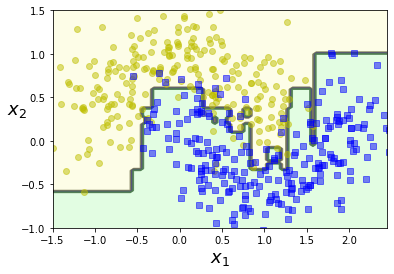

In [23]:
plot_decision_boundary(ada_clf, X, y)

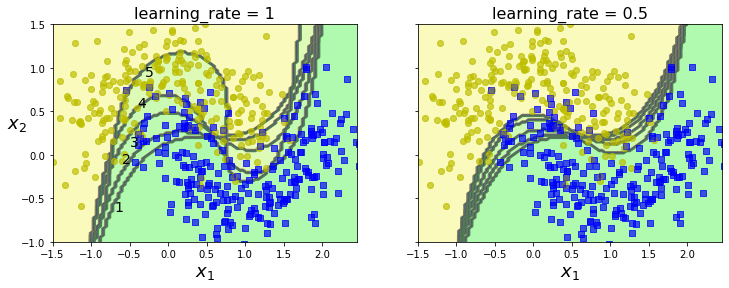

In [24]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(12,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

Una vez que se han entrenado todos los predictores, el conjunto hace predicciones muy parecidas a las de bagging o pasting, excepto que los predictores tienen diferentes pesos dependiendo de su precisión global en el conjunto de entrenamiento ponderado.

---

Hay una desventaja importante en esta técnica de aprendizaje secuencial: no puede ser paralelizada (o solo parcialmente), dado que cada predictor solo puede ser entrenado después de que el predictor precedente haya sido entrenado y evaluado. Como resultado, no escala también como bagging o pasting.

---

Echemos un vistazo más de cerca al algoritmo de AdaBoost. Cada peso de instancia $w^{(i)}$ se establece inicialmente a $\frac{1}{m}$. Se entrena un primer predictor y su tasa de error ponderada $r_1$ se calcula en el conjunto de entrenamiento; ver la siguiente ecuación:

***Tasa de error ponderada del predictor j-ésimo***

![error_rate](images/ch07/error_rate.png)

donde $\hat{y}_j^{(i)}$ es el la predicción del predictor *j-ésimo* para la instancia *i-ésima*.

El peso $\alpha_j$ del predictor se calcula entonces usando la siguiente fórmula, donde $\eta$ es el hiperparámetro de tasa de aprendizaje, por defecto a 1 (el algoritmo AdaBoost original no usa el hiperparámetro de tasa de aprendizaje). Cuanto más preciso sea el predictor, mayor será su peso. Si solo está adivinando al azar, entonces su peso estaría próximo a cero. Sin embargo, si con frecuencia es incorrecto (es decir, menos preciso que adivinar al azar), entonces su peso sería negativo.

***Peso del predictor***

$\alpha_j = \eta \, log \, \frac{1 - r_j}{r_j}$

A continuación, se actualizan los pesos de las instancias usando la siguiente ecuación: las instancias mal clasificadas se incrementan (boosted):

***Regla de actualización de pesos***

Para *i = 1, 2, ..., m*

![weight_rule](images/ch07/weight_rule.png)

Luego todos los pesos de las instancias son normalizados (es decir, divididos por $\sum_{i=1}^m w^{(i)}$).

Finalmente se entrena un nuevo predictor usando los pesos actualizados y se repite todo el proceso completo (se calcula el peso del nuevo predictor, se actualizan los pesos de las instancias y luego se entrena otro predictor, y así sucesivamente). El algoritmo se detiene cuando se alcanza el número deseado de predictores o cuando se encuentra un predictor perfecto.

Para hacer predicciones, AdaBoost simplemente calcula las predicciones de todos los predictores y los pesa usando los pesos $\alpha_j$ de los predictores. La clase predicha es la que recibe la mayoría de los votos ponderados (ver la siguiente ecuación).

***Predicciones AdaBoost***

![adaboost_predictions](images/ch07/adaboost_predictions.png)

donde *N* es el número de predictores.

En realidad, Scikit-Learn usa un versión multiclase de AdaBoost llamada *[SAMME](https://homl.info/27)*, que significa Modelado Aditivo por Etapas usando una función de pérdida Exponencial Multiclase (*Stagewise Additive Modeling using a Multiclass Exponential loss function*). Cuando solo hay dos clases, SAMME es equivalente a AdaBoost. Además, si los predictores pueden estimar probabilidades de clases (es decir, tienen un método `predict_proba()`), Scikit-Learn puede usar una variante de SAMME denominada SAMME.R (la *R* significa "Real"), que se basa en las probabilidades de clase en lugar de predicciones y generalmente se ejecuta mejor.

El código anterior entrena un clasificador AdaBoost basado en 200 *tocones de decisión* usando la clase `AdaBoostClassifier` de Scikit-Learn (como cabría esperar, también existe una clase `AdaBoostRegressor`). Un tocón de decisión es un árbol de decision con `max_depth=1`. En otras palabras, un árbol compuesto por un único nodo de decisión más dos nodos hoja. Este es el estimador base por defecto para la clase `AdaBoostClassifier`:

---

Si nuestro conjunto AdaBoost está sobreajustando el conjunto de entrenamiento, podemos reducir el número de estimadores o regularizar con mayor fuerza el estimador base.

---

## Gradient Boosting

Otro algoritmo Boosting muy popular es *[Gradient Boosting](https://homl.info/28)*. Al igual que AdaBoost, Gradient Boosting trabaja añadiendo predictores secuencialmente a un conjunto, cada uno de ellos corrigiendo a su predecesor. Sin embargo, en lugar de ajustar los pesos de las instancias a cada iteración como hace AdaBoost, este método intenta ajusta el nuevo predictor a los *errores residuales* realizados por el predictor previo.

Veamos un ejemplo de regresión simple usando árboles de decisión como predictores base (por supuesto Gradient Boosting también funciona con tareas de regresión). Esto se denomina *Gradient Tree Boosting* o *Gradient Boosted Regression Trees (GBRT)*. Primero, ajustemos un `DecisionTreeRegressor` al conjunto de entrenamiento (por ejemplo, un conjunto de entrenamiento cuadrático ruidoso):

In [27]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [28]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Ahora entrenemos un segundo `DecisionTreeRegressor` en los errores residuales generados por el primer predictor:

In [29]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Después entrenamos un tercer regresor en los errores residuales generados por el segundo predictor:

In [30]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Ahora tenemos un conjunto conteniendo tres árboles. Podemos hacer predicciones en una nueva instancia simplemente añadiendo las predicciones de los tres árboles:

In [31]:
X_new = np.array([[0.8]])

In [32]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

y_pred

array([0.75026781])

La siguiente figura representa las predicciones de estos tres árboles en la columna izquierda y las predicciones del conjunto en la columna derecha. En la primera fila, el conjunto tiene solo un árbol, por tanto sus predicciones son exactamente las mismas que las predicciones del primero de los tres árboles. En la segunda fila, se ha entrenado un nuevo árbol en los errores residuales del primer árbol. En la derecha podemos ver que las predicciones del conjunto son iguales a la suma de las predicciones de los primeros dos árboles. De forma similar, en la tercera fila se ha entrenado otro árbol en los errores residuales del segundo árbol. Podemos ver que las predicciones del conjunto mejoran gradualmente según se van añadiendo árboles al conjunto.

In [33]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

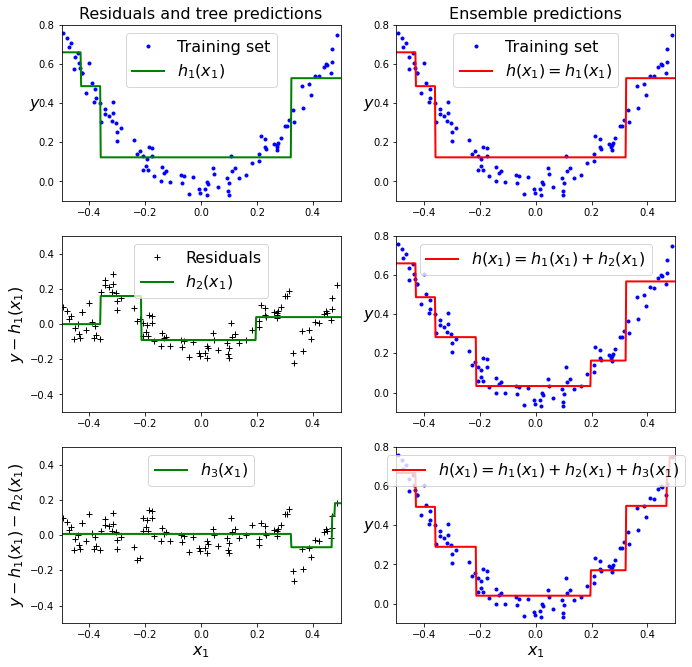

In [35]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.show()

Una forma sencilla de entrenar un conjunto GBRT es usar la clase de Scikit-Learn `GradientBoostingRegressor`. Al igual que la clase `RandomForestRegressor`, tiene hiperparámetros para controlar el crecimiento de loas árboles de decisión (es decir, `max_depth`, `min_samples_leaf`, y así sucesivamente), así como hiperparámetros para controlar el entrenamiento del conjunto, como el número de árboles (`n_estimators`). El código siguiente crea el mismo conjunto que el anterior:

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

El hiperparámetro `learning_rate` escala la contribución de cada árbol. Si lo establecemos a una valor bajo, como `0.1`, necesitaremos más árboles en el conjunto para ajustar el conjunto de entrenamiento, pero las predicciones normalmente generalizarán mejor. Esta es una técnica de regularización denominada *contracción* (*shrinkage*). La siguiente figura muestra dos conjuntos GBRT entrenados con un `learning_rate` bajo: el de la izquierda no tiene suficientes árboles para ajustar el conjunto de entrenamiento, mientras que el de la derecha tiene demasiados árboles y sobreajusta el conjunto de entrneamiento.

In [37]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

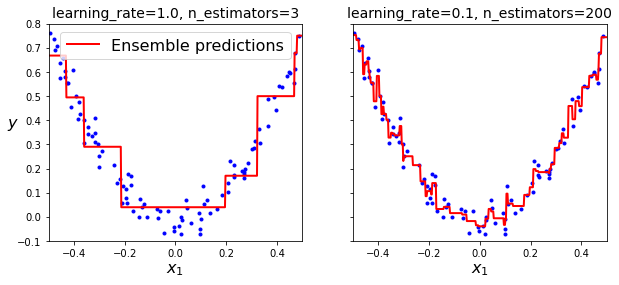

In [38]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

Para encontrar el número óptimo de árboles, podemos usar detención temprana (que vimos en el capítulo 4). Una forma sencilla de implementar esto es usar el método `staged_predict()`: devuelve un iterador sobre las predicciones hechas por el conjunto en cada etapa de entrenamiento (con un árbol, dos árboles, etc.). El siguiente código entrena un conjunto GBRT con 120 árboles, luego mide el error de validación en cada etapa del entrenamiento para encontrar el número óptimo de árboles y, finalmente, entrena otro conjunto GBRT usando el número óptimo de árboles:

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [40]:
min_error = np.min(errors)

min_error

0.002712853325235463

Los errores de validación están representados a la izquierda de la siguiente figura y las predicciones del mejor modelo están representadas a la derecha.

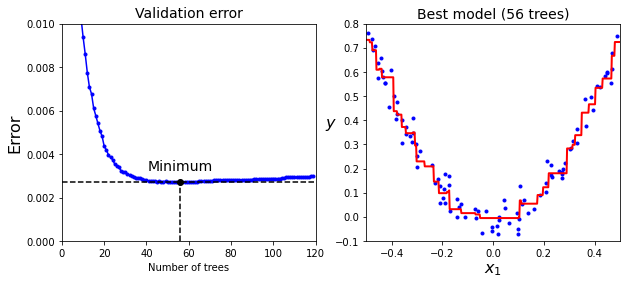

In [41]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

También es posible implementar detención temprana al detener realmente el entrenamiento temprano (en lugar de entrenar primero un número grande de árboles y luego volver para encontrar el número óptimo). Podemos hacerlo estableciendo `warm_start=True`, que hace que Scikit-Learn mantenga los árboles existentes cuando se llama al método `fit()`, permitiendo entrenamiento incremental. El código siguiente detiene el entrenamiento cuando el error de validación no mejora tras cinco iteraciones seguidas:

In [42]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [43]:
print(gbrt.n_estimators)

61


In [44]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


La clase `GradientBoostingRegressor` también admite un hiperparámetro `subsample`, que especifica la fracción de instancias de entrenamiento a usar para entrenar cada árbol. Por ejemplo, si `subsample=0.25` entonces cada árbol se entrena en un 25% de las instancias de entrenamiento, seleccionadas aleatoriamente. Como probablemente hayas adivinado, esto intercambia un alto sesgo por una menor varianza. También acelera considerablemente el entrenamiento. Esta técnica se denomina *Gradient Boosting Estocástico*.

---

Es posible usar Gradient Boosting con otras funciones de coste. Este se controla con el hiperparámetro `loss`.

---

Vale la pensa señalar que una implementación optimizada de Gradient Boosting está disponible en la popular librería de python *[XGBoost](https://github.com/dmlc/xgboost)*, que significa Gradient Boosting Extremo. Este package fue inicialmente desarrollado por Tianqi Chen como parte de la Comunidad de Machine Learning Distribuida Profunda ([DMLC](http://dmlc.ml/)) y tiene como objetivo ser extremadamente rápido, escalable y portable. De hecho, XGBoost es a menudo un componente importante de las entradas ganadoras en las competiciones de Machine Learning. La API de XGBoost es bastante similar a la de Scikit-Learn:

In [46]:
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

Validation MSE: 0.00400040950714611


XGBoost también ofrece varias características interesantes, tales como cuidar automáticamente de la detención temprana:

In [47]:
xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.22834
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Stopping. Best iteration:
[7]	validation_0-rmse:0.05129

Validation MSE: 0.0026308690413069744


In [48]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train)

15.9 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

18 ms ± 19.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
